In [2]:
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt

### System parameters

In [149]:
L = 100
x,dx = np.linspace(-5,5,L+1,retstep=True)

## Operators

In [150]:
X = np.diag(x)
# Let's figure out how the momentum operator acts on a state
# P = i * d/dx, so P Psi(x) => i * (Psi(x+dx) - Psi(x)), but we'll make it symmetric:
# P Psi(x) => i * ( (Psi(x + dx) - Psi(x)) + (Psi(x) - Psi(x-dx)) ) = i * (Psi(x+dx) - Psi(x-dx))
# So as a matrix:
P = 1j * (np.diag(np.ones(L), k=1) - np.diag(np.ones(L), k=-1))

## Free particle test

In [151]:
def gaussian(x, x0, sigma):
    normalization = 1/(np.sqrt(2*np.pi)*sigma)
    return np.exp(-1/2 * (x-x0)**2/sigma**2 ) * normalization

def gaussian_amplitude(x, x0, sigma):
    normalization = 1/(np.sqrt(np.sqrt(2*np.pi*sigma**2)))
    return np.exp(-1/4 * (x-x0)**2/sigma**2 ) * normalization

In [152]:
H = np.dot(P,P)/2 # Free particle, just P^2

# Time evolution operator
dt = 0.01
U = sp.linalg.expm(1j * H * dt)

0.9999999999999999
After evolution, the wavefunction's norm is: 1.000000000000065


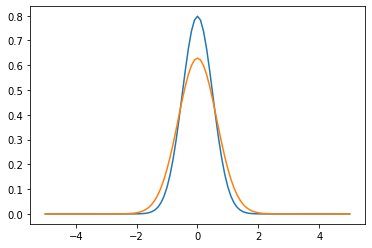

In [165]:
# Initial wavefunction
psi = gaussian_amplitude(x, 0, 0.5)
# Normalize it
#psi /= np.linalg.norm(psi)
print(np.sum(np.abs(psi)**2)*dx)

plt.plot(x,np.abs(psi)**2)

for step in range(1000):
    psi = np.dot(U, psi)

plt.plot(x,np.abs(psi)**2)
print("After evolution, the wavefunction's norm is: {0}".format(np.sum(np.abs(psi)**2*dx)))

## Momentum kick operator

In [166]:
kickstrength = 1
RightKick = sp.linalg.expm( -1j * X * kickstrength )
LeftKick = sp.linalg.expm( 1j * X * kickstrength )

After evolution, the wavefunction's norm is: 1.000000000000044


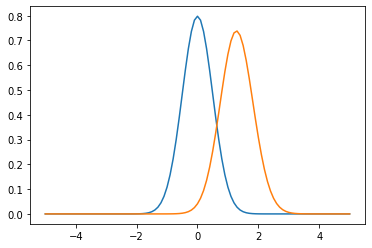

In [167]:
# Initial wavefunction
psi = gaussian_amplitude(x, 0, 0.5)
# Normalize it
#psi /= np.linalg.norm(psi)

plt.plot(x,np.abs(psi)**2)

for step in range(1000):
    psi = np.dot(U, psi)
    
    # Kick every so often
    if( step != 0 and step % 100 == 0 ):
        psi = np.dot(RightKick, psi)

plt.plot(x,np.abs(psi)**2)
print("After evolution, the wavefunction's norm is: {0}".format(np.sum(np.abs(psi)**2*dx)))

## Weak measurements

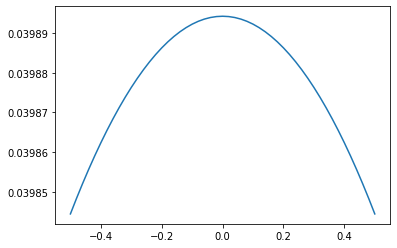

In [168]:
coupling_strength = 1
coupling_time = 0.1
cst = coupling_strength * coupling_time

# The number of positions for our needle
Nq = 50
minX = np.min(x)
maxX = np.max(x)
minQ = minX * cst
maxQ = maxX * cst
q,dq = np.linspace(minQ,maxQ,Nq+1,retstep=True)

# Our needle starts at q = 0
phi = gaussian_amplitude(q, 0, 10)
#phi /= np.linalg.norm(phi)
plt.plot(q, np.abs(phi)**2)

In [208]:
# The momentum operator for q
Pq = 1j * (np.diag(np.ones(Nq), k=1) - np.diag(np.ones(Nq), k=-1))

In [233]:
q_phi = phi * dq
q_p_phi = np.dot(Pq, phi) * dq 
q_p2_phi = np.dot( np.dot(Pq, Pq), phi ) * dq

M = []
E = []
for i in range(len(q)):
    M.append( q_phi[i] * np.eye(L+1) - 1j * cst * X * q_p_phi[i] - 0.5 * cst**2 * np.dot(X, X) * q_p2_phi[i] )
    E.append( np.dot(M[i].conj().T, M[i]) )

In [234]:
totE = np.sum(E,axis=0)
print(totE.shape)
print(totE)

(101, 101)
[[0.00081399+0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.        +0.j]
 [0.        +0.j 0.00081395+0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.00081391+0.j ... 0.        +0.j
  0.        +0.j 0.        +0.j]
 ...
 [0.        +0.j 0.        +0.j 0.        +0.j ... 0.00081391+0.j
  0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  0.00081395+0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.00081399+0.j]]


### Perform measurement

In [224]:
np.random.seed(1990)

Weak measurment probabilities for each q sum to 9.99886189149602
The weakly measured value is: 0.2400


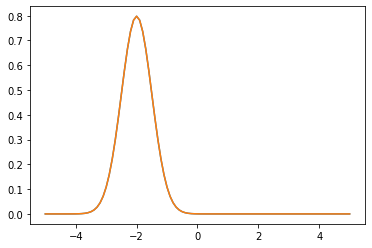

In [225]:
# Initial wavefunction
psi = gaussian_amplitude(x, -2, 0.5)
# Normalize it
#psi /= np.linalg.norm(psi)

plt.plot(x,np.abs(psi)**2)

probs = np.zeros(len(q))
for i in range(len(q)):
    # E is Hermitian, so expectation values are real
    probs[i] = np.real( np.dot( psi.conj().T, np.dot( E[i], psi )) )

print("Weak measurment probabilities for each q sum to {0}".format(np.sum(probs)))

# Pick one!
measurement_result = np.random.choice(range(len(q)), p=probs/np.sum(probs))

print("The weakly measured value is: %.4f"%q[measurement_result])
# So the needle shifted by q, corresponding to (lambda * dt * X) -> X = q / (lmda * dt)
#print("Corresponding to position: %.4f"%(q[measurement_result] / cst))

# Update the wavefunction
psi = np.dot(M[measurement_result], psi)
# Normalize it
psi /= np.sqrt(np.dot(psi.conj().T,psi)*dx)

# Update the measurement needle to where we measured
# phi = delta function at q[measurement_result]
# But we will reset phi for the next measurement anyway, so we don't actually need this

plt.plot(x,np.abs(psi)**2)

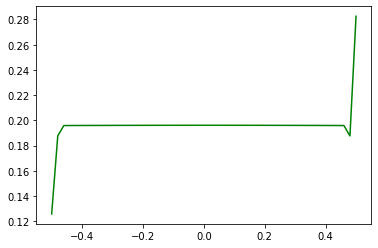

In [226]:
plt.plot(q, probs, c='green')

But many weak measurements of position do


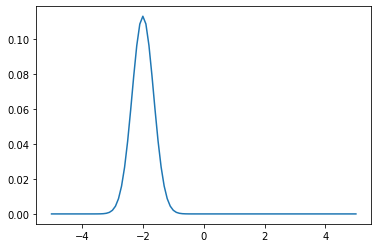

In [73]:
# Initial wavefunction
psi = gaussian(x, -2, 0.5)
# Normalize it
psi /= np.linalg.norm(psi)

plt.plot(x,np.abs(psi)**2)

weak_measurements = []
positions = []
for wm in range(5000):
    probs = np.zeros(len(q))
    for i in range(len(q)):
        # E is Hermitian, so expectation values are real
        probs[i] = np.real( np.dot( psi.conj().T, np.dot( E[i], psi )) )

    # Pick one!
    measurement_result = np.random.choice(range(len(q)), p=probs/np.sum(probs))

    weak_measurements.append(q[measurement_result])
    positions.append( q[measurement_result] / cst )

    # Update the wavefunction
    psi = np.dot(M[measurement_result], psi)
    # Normalize it
    psi /= np.linalg.norm(psi)

# Update the measurement needle to where we measured
# phi = delta function at q[measurement_result]
# But we will reset phi for the next measurement anyway, so we don't actually need this

plt.plot(x,np.abs(psi)**2)

print("But many weak measurements of position do")

(array([   6.,   54.,  183.,  902., 1076., 1564.,  910.,  217.,   80.,
           8.]),
 array([-2.6 , -2.08, -1.56, -1.04, -0.52,  0.  ,  0.52,  1.04,  1.56,
         2.08,  2.6 ]),
 <a list of 10 Patch objects>)

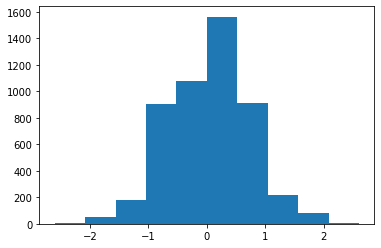

In [74]:
plt.hist(positions)